In [247]:
# Install necessary packages
%pip install openmeteo-requests
%pip install requests-cache retry-requests numpy pandas


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [261]:
# Import dependencies
import openmeteo_requests
import requests_cache
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import os

from retry_requests import retry
from dotenv import load_dotenv, find_dotenv


# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)


In [249]:
## WEATHER DATA:


In [250]:
# Setup Open-Meteo base request
open_meteo_base_url = "https://archive-api.open-meteo.com/v1/archive"

open_meteo_base_params = {
	"start_date": "2019-01-01",
	"end_date": "2023-12-31",
	"daily": ["temperature_2m_mean", "precipitation_sum"],
	"temperature_unit": "fahrenheit",
	"wind_speed_unit": "mph",
	"precipitation_unit": "inch"
}


In [251]:
# Honolulu Weather: Get Data
honoalulu_params = {
    **open_meteo_base_params,
    "latitude": 21.3069,  
    "longitude": -157.8583
}

responses = openmeteo.weather_api(open_meteo_base_url, params=honoalulu_params)
honolulu_response = response = responses[0]


In [252]:
# Honolulu Weather: Process Data
daily = honolulu_response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(1).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["Mean Temperature (f)"] = daily_temperature_2m_mean
daily_data["Total Precipitation (in)"] = daily_precipitation_sum


In [253]:
# Honolulu Weather: Remove NA and Normailze date format
honolulu_daily_df = pd.DataFrame(data = daily_data).dropna(how='any' )
honolulu_daily_df['date'] = honolulu_daily_df['date'].dt.tz_localize(None)

honolulu_daily_df.head()


,date,Mean Temperature (f),Total Precipitation (in)
0,2019-01-01,75.174347,0.003937
1,2019-01-02,74.825607,0.000000
2,2019-01-03,74.308105,0.011811
3,2019-01-04,74.338097,0.000000
4,2019-01-05,74.004356,0.000000


In [254]:
# Honolulu Weather: Convert daily data to monthly 
honolulu_daily_df.set_index('date', inplace=True)
honolulu_monthly_df = honolulu_daily_df.resample('M').mean()

honolulu_monthly_df.reset_index(inplace=True)
honolulu_monthly_df['date'] = honolulu_monthly_df['date'].dt.strftime('%m/%Y')
honolulu_monthly_df.rename(columns={'date': 'Date'}, inplace=True)

honolulu_monthly_df.head()


C:\Users\HollidayDDS\AppData\Local\Temp\ipykernel_31488\2007540429.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  honolulu_monthly_df = honolulu_daily_df.resample('M').mean()


,Date,Mean Temperature (f),Total Precipitation (in)
0,01/2019,72.986885,0.031496
1,02/2019,69.448105,0.079021
2,03/2019,72.239670,0.009779
3,04/2019,75.143097,0.028609
4,05/2019,76.997574,0.068580


In [255]:
## ENERGY DATA

In [256]:
# Load EIA Api Key
load_dotenv(find_dotenv("local_keys.env"))
eia_key = os.getenv("eia")

# Setup EIA Energy API URL
eia_base_url = f"https://api.eia.gov/v2/electricity/retail-sales/data/?api_key={eia_key}"


In [257]:
# Honolulu Energy: Get Data
hawaii_energy_args = f'&frequency=monthly&data[0]=price&data[1]=sales&facets[stateid][]=HI&facets[sectorid][]=ALL&start=2019-01&end=2023-12&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'

eia_hawaii_response = requests.get(eia_base_url + hawaii_energy_args)

eia_hawaii_response_object = eia_hawaii_response.json()
eia_hawaii_response_data = eia_hawaii_response_object['response']['data']

hawaii_energy_df = pd.DataFrame(eia_hawaii_response_data)
hawaii_energy_df.head()


,period,stateid,stateDescription,sectorid,sectorName,price,sales,price-units,sales-units
0,2023-12,HI,Hawaii,ALL,all sectors,38.56,748.42486,cents per kilowatt-hour,million kilowatt hours
1,2023-11,HI,Hawaii,ALL,all sectors,39.85,759.7187,cents per kilowatt-hour,million kilowatt hours
2,2023-10,HI,Hawaii,ALL,all sectors,38.71,793.85968,cents per kilowatt-hour,million kilowatt hours
3,2023-09,HI,Hawaii,ALL,all sectors,36.75,768.21188,cents per kilowatt-hour,million kilowatt hours
4,2023-08,HI,Hawaii,ALL,all sectors,35.37,793.19382,cents per kilowatt-hour,million kilowatt hours


In [258]:
# Honolulu Energy: Clean Data
hawaii_energy_df.drop(columns=['stateid', 'sectorid', 'stateDescription', 'sectorName', 'price-units', 'sales-units'], inplace=True)
hawaii_energy_df.head()

hawaii_energy_df.rename(columns={
    'period': 'Date',
    'price': 'Unit Price',
    'sales': 'Sales'
}, inplace=True)

# Convert 'Unit Price' and 'Sales' to numeric (float)
hawaii_energy_df['Unit Price'] = pd.to_numeric(hawaii_energy_df['Unit Price'], errors='coerce')
hawaii_energy_df['Sales'] = pd.to_numeric(hawaii_energy_df['Sales'], errors='coerce')

hawaii_energy_df['Date'] = pd.to_datetime(hawaii_energy_df['Date'])
hawaii_energy_df['Date'] = hawaii_energy_df['Date'].dt.tz_localize(None)
hawaii_energy_df['Date'] = hawaii_energy_df['Date'].dt.strftime('%m/%Y')

hawaii_energy_df.head()


,Date,Unit Price,Sales
0,12/2023,38.56,748.42486
1,11/2023,39.85,759.71870
2,10/2023,38.71,793.85968
3,09/2023,36.75,768.21188
4,08/2023,35.37,793.19382


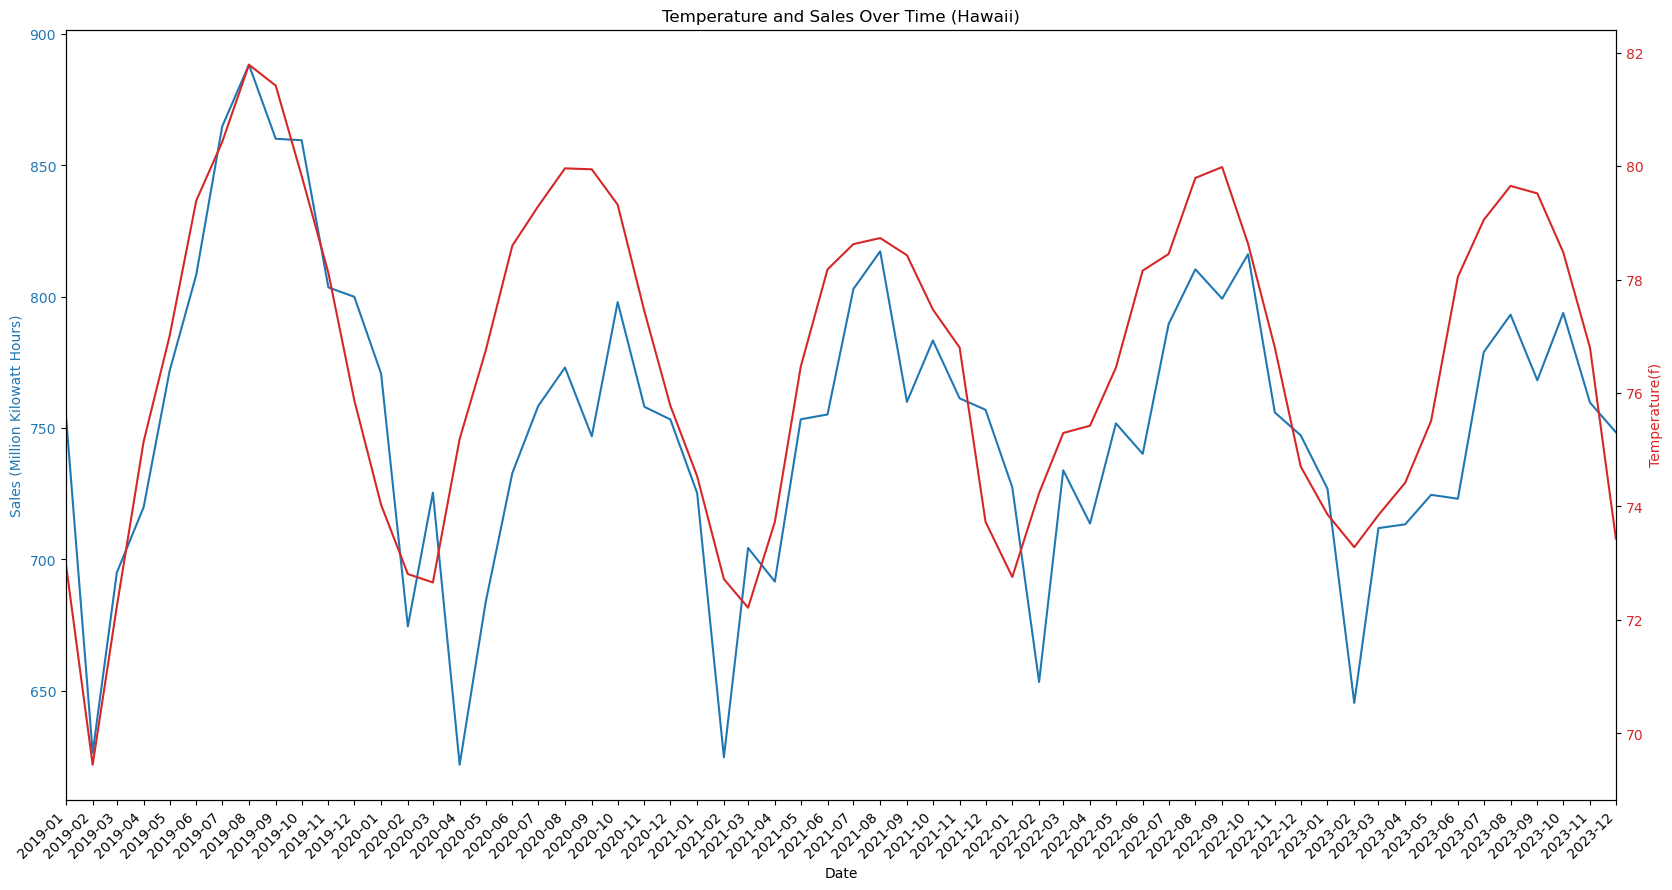

In [291]:
## TODO: ADD Plots Below

# Merge the DataFrames on the 'Date' column
merged_df = pd.merge(hawaii_energy_df, honolulu_monthly_df, left_on='Date', right_on='Date')
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%m/%Y', errors='coerce')

merged_df.head()

# Plotting
fig, ax1 = plt.subplots(figsize = (20,10))

# Plot Unit Price on the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales (Million Kilowatt Hours)', color='tab:blue')
ax1.plot(merged_df['Date'], merged_df['Sales'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for Temperature
ax2 = ax1.twinx()
ax2.set_ylabel('Temperature(f)', color='tab:red')
ax2.plot(merged_df['Date'], merged_df['Mean Temperature (f)'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Manually set the x-tick labels
ax1.set_xticks(merged_df['Date'][::1])  # Adjust the step to show more or fewer labels
ax1.set_xticklabels(merged_df['Date'][::1].dt.strftime('%Y-%m'))

# Rotate the x-axis labels
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Set x-axis limits to the range of your data
ax1.set_xlim([merged_df['Date'].min(), merged_df['Date'].max()])

plt.title('Temperature and Sales Over Time (Hawaii)')
plt.show()

# Export dataframe to a csv
merged_df.to_csv('Output/hawaii_temp_vs_sales.csv', index=False)
